# Multi-Product Sales Forecast

Sales forecasting is key not only to the sales department but to the whole organization. A good forecast will allow to align resources and focus on the right objectives. But above anything, an acurate forecast will get the company closer to business goals and provide stability to the organization.

Traditionally, sales forecasting is based on personal judging with very little, or no support at all, of any other tools. Data Science can help make better forecasts, especially in the context of multi-product forecasts.

In this project we explore the possibility of building a single model to get sales predictions for multiple products. Instead of fitting one model per product, we will explore if fitting one model for all products provides a good enough prediction for all products. In Machine Learning, more data is always better. The main benefit of this approach is that we will have more training data.

Dataset source: http://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly

The dataset is taken from the UCI repository and contains weekly sales of 800+ products. Data is provided both normalised and non-normalised. The data is organised per product code. Each row contains sold quantities over 52 weeks for one product. Find below the list of attributes:
* Product_Code
* Weekly sales per product (52 weeks): W0, W1, .... W51
* Normalised sales data: Normalized 0, Normalized 1, ... Normalized 51
* MIN: minimum quantity sold per product
* MAX: maximum quantity sold per product

In this project, we learnt that using all time series to train a single model allow for capturing more patterns that repeat across multiple series. These patterns cannot be learnt by fitting one model per serries since, for some series, there are very little data. With the single-model approach, the common patterns are leveraged to make predictions for any product. The product is an input variable to oor model.  

## Library Imports

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning, UserWarning
import warnings

import xgboost as xgb

In [125]:
pd.set_option('display.max_columns', 120)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UserWarning, append=True)

## Exploratory Analysis



In [159]:
df = pd.read_csv('../data/raw/Sales_Transactions_Dataset_Weekly.csv')
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51,MIN,MAX,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,Normalized 10,Normalized 11,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10,3,21,0.44,0.50,0.39,0.28,0.56,0.50,0.61,1.00,0.17,0.61,0.44,0.61,0.72,0.33,0.33,0.33,0.61,0.33,0.00,0.50,0.11,0.44,0.22,0.50,0.11,0.33,0.22,0.39,0.11,0.44,0.22,0.39,0.50,0.17,0.11,0.61,0.39,0.33,0.50,0.78,0.22,0.44,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0,0,10,0.70,0.60,0.30,0.20,0.70,0.10,0.60,0.30,0.30,0.30,0.20,0.20,0.60,0.20,0.00,0.60,0.20,0.70,0.70,0.90,0.40,0.70,0.20,0.40,0.50,0.30,0.50,0.80,0.50,0.50,0.30,0.10,0.30,0.20,0.30,1.00,0.50,0.20,0.70,0.30,0.20,0.50,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7,3,14,0.36,0.73,0.45,0.55,0.64,0.45,0.36,0.91,0.82,0.27,1.00,0.55,0.09,0.36,0.82,0.45,0.36,0.73,0.64,0.36,0.36,0.91,0.73,0.45,0.64,0.45,1.00,0.18,0.00,0.91,0.73,0.55,0.36,0.45,0.36,0.55,0.27,0.82,0.82,0.55,0.00,0.18,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8,2,19,0.59,0.35,0.65,0.18,0.41,0.24,0.41,0.65,0.65,0.53,0.35,0.12,0.18,0.12,0.76,0.29,0.53,0.41,0.76,0.12,0.24,0.29,0.53,0.29,0.41,0.24,0.47,0.47,0.00,0.24,0.29,0.00,0.18,0.59,0.18,1.00,0.35,0.24,0.35,0.35,0.59,0.24,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9,3,18,0.33,0.13,0.67,0.53,0.20,0.27,0.40,0.73,0.40,0.40,0.53,1.00,0.33,0.07,0.67,0.33,0.47,0.80,0.20,0.67,0.53,0.20,0.47,0.40,0.33,0.60,0.33,0.40,0.67,0.00,0.13,0.00,0.13,0.13,0.40,0.27,0.07,0.33,0.33,0.13,0.13,0.33,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [10]:
df.tail()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51,MIN,MAX,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,Normalized 10,Normalized 11,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
806,P815,0,0,1,0,0,2,1,0,0,1,0,0,1,0,1,1,3,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,2,1,0,0,1,1,0,0,1,0,0,2,0,0,3,0.00,0.00,0.33,0.0,0.00,0.67,0.33,0.00,0.00,0.33,0.0,0.00,0.33,0.0,0.33,0.33,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.33,0.00,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.67,0.33,0.00,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,1,0,2,2,0,5,1,1,1,2,3,1,0,2,1,7,3,3,3,2,2,3,1,1,4,5,4,3,2,4,6,6,7,3,3,4,2,4,5,5,5,6,5,0,7,0.00,0.14,0.00,0.0,0.14,0.29,0.29,0.86,0.00,0.14,0.0,0.29,0.29,0.0,0.71,0.14,0.14,0.14,0.29,0.43,0.14,0.0,0.29,0.14,1.00,0.43,0.43,0.43,0.29,0.29,0.43,0.14,0.14,0.57,0.71,0.57,0.43,0.29,0.57,0.86,0.86,1.00,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,2,2,0,0,0,4,3,0,4,0.25,0.00,0.00,0.0,0.25,0.25,0.50,0.25,0.25,0.00,0.0,0.25,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.0,0.00,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,2,0.00,0.00,0.00,0.5,0.00,0.00,0.00,0.00,0.50,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.0,0.50,0.00,1.00,0.50,0.50,0.00,0.50,0.50,0.00,0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00
810,P819,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,3,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3,0.00,0.33,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.67,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,1.00,0.33,0.33,0.33,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33


In [11]:
df.shape

(811, 107)

In [12]:
df.dtypes

Product_Code      object
W0                 int64
W1                 int64
W2                 int64
W3                 int64
                  ...   
Normalized 47    float64
Normalized 48    float64
Normalized 49    float64
Normalized 50    float64
Normalized 51    float64
Length: 107, dtype: object

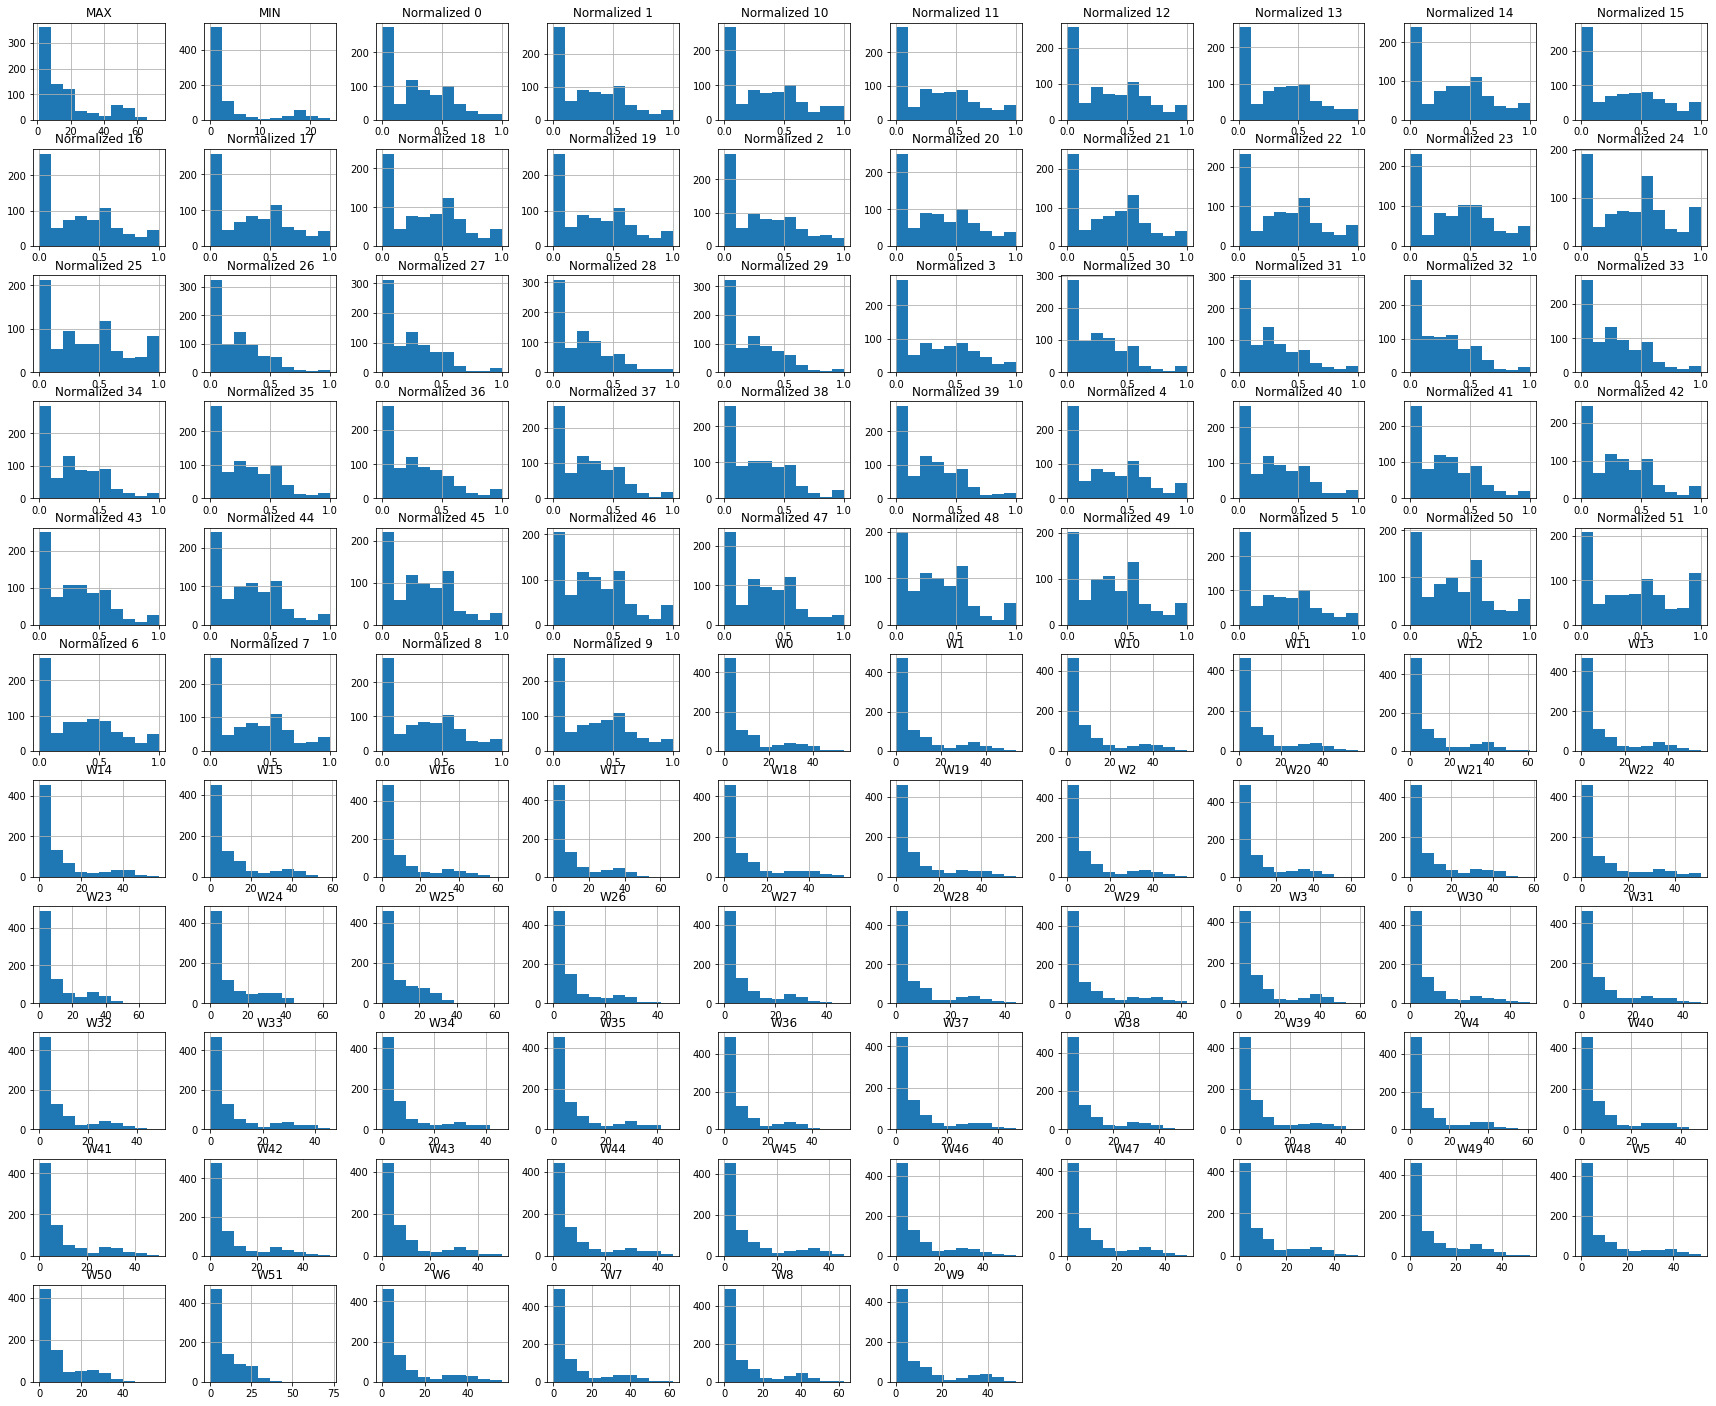

In [20]:
df.hist(figsize=(30,25))
plt.show()

Low quantities are the dominant value across all weeks. Let's check summary statistics:

In [21]:
df.describe()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51,MIN,MAX,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,Normalized 10,Normalized 11,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.00000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.00000,811.000000,811.000000,811.000000
mean,8.902589,9.129470,9.389642,9.717633,9.574599,9.466091,9.720099,9.585697,9.784217,9.681874,9.790382,9.678175,9.827374,9.686806,9.907522,10.045623,10.033292,9.905055,10.007398,9.644883,9.849568,9.710234,9.902589,9.861899,10.166461,8.892725,6.950678,7.193588,7.383477,7.339088,7.607891,7.610358,7.759556,7.906289,7.992602,7.997534,8.014797,8.073983,8.251541,7.965475,8.182491,8.240444,8.394575,8.318126,8.434032,8.556104,8.720099,8.670777,8.674476,8.895191,8.861899,8.889026,3.780518,16.308261,0.289396,0.299100,0.306732,0.319852,0.326905,0.319420,0.332848,0.326572,0.32434,0.326843,0.331134,0.331455,0.338878,0.331591,0.355771,0.344821,0.335919,0.345253,0.354994,0.330210,0.340271,0.353551,0.366017,0.370629,0.417694,0.389618,0.207596,0.223046,0.229605,0.224365,0.240493,0.250395,0.248323,0.259371,0.262256,0.268903,0.270173,0.273144,0.277497,0.264994,0.286375,0.279396,0.299149,0.287571,0.304846,0.316017,0.334760,0.314636,0.33815,0.358903,0.373009,0.427941
std,12.067163,12.564766,13.045073,13.553294,13.095765,12.823195,13.347375,13.049138,13.550237,13.137916,13.577685,13.007548,13.366525,13.214865,13.389975,13.743655,13.890316,13.364486,13.560015,13.129259,13.473781,12.827964,13.003290,12.617572,12.298777,10.016879,9.449151,9.729464,10.187970,10.161884,10.600332,10.390931,10.714137,10.838140,10.824638,10.773653,10.950947,10.854683,11.272094,10.758691,11.078674,11.141299,11.348777,11.250455,11.223499,11.382041,11.621684,11.435870,11.222996,10.941375,10.492710,9.558011,6.403214,17.150637,0.266307,0.281343,0.284234,0.296498,0.297291,0.292765,0.301855,0.298986,0.29320,0.292093,0.301031,0.304610,0.299536,0.289895,0.300587,0.312811,0.301809,0.302416,0.299286,0.297747,0.299420,0.294376,0.304491,0.303188,0.315159,0.323586,0.214272,0.226805,0.229479,0.229580,0.235536,0.248798,0.237675,0.247164,0.248657,0.249708,0.257877,0.248350,0.253397,0.246666,0.262363,0.253084,0.266993,0.256630,0.263396

There are no missing values and data in general makes perfect sense.

## Data Cleaning
As per exploratory analysis, data is clean. We only need to structure it in way it is easier for modeling (i.e. tidy dataset). In this case we have values of the variable week as column names. We need to melt the dataset, renaming the column to "Week" and values to "Sales". For our analysis, we only need weekly sales. Therefore, first, we remove the following columns: MIN, MAX and Normalized N (all normalized data columns) and convert "Product_Code" to a numerical feature by extracting the numerical value from the original feature:

In [160]:
columns = ['Normalized ' + str(n) for n in range(52)]
columns += ['MIN', 'MAX']
df = df.drop(columns, axis='columns')
print(df.shape)
df.head()

(811, 53)


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9


In [161]:
df.Product_Code = df.Product_Code.str.replace('P', '')
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0
2,3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7
3,4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8
4,5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9


In [162]:
df.Product_Code = df.Product_Code.astype(int)
df.dtypes

Product_Code    int64
W0              int64
W1              int64
W2              int64
W3              int64
W4              int64
W5              int64
W6              int64
W7              int64
W8              int64
W9              int64
W10             int64
W11             int64
W12             int64
W13             int64
W14             int64
W15             int64
W16             int64
W17             int64
W18             int64
W19             int64
W20             int64
W21             int64
W22             int64
W23             int64
W24             int64
W25             int64
W26             int64
W27             int64
W28             int64
W29             int64
W30             int64
W31             int64
W32             int64
W33             int64
W34             int64
W35             int64
W36             int64
W37             int64
W38             int64
W39             int64
W40             int64
W41             int64
W42             int64
W43             int64
W44       

In [163]:
molten_df = df.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
molten_df.head()

,Product_Code,Week,Sales
0,1,W0,11
1,2,W0,7
2,3,W0,7
3,4,W0,12
4,5,W0,8


In [164]:
molten_df.Week = molten_df.Week.str.replace('W', '')
molten_df.head(10)

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
5,6,0,3
6,7,0,4
7,8,0,8
8,9,0,14
9,10,0,22


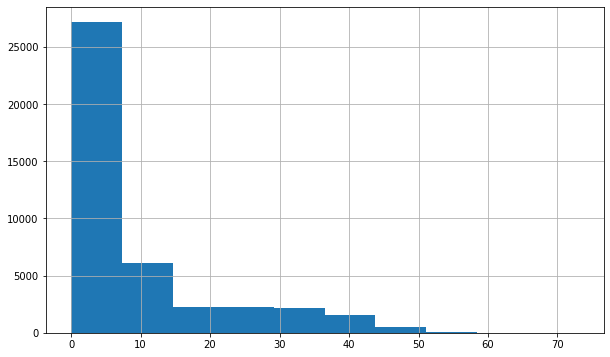

In [166]:
molten_df.Sales.hist(figsize=(10, 6))
plt.show()

As per the histogram above, we see that a lot of items sell very little quantities. So we should expect the error to look "high".

In [37]:
molten_df.to_csv('../data/processed/clean.csv')

## Feature Engineering
In this section we will create lags and difference features:
* Last_Week_Sales: quantities sold the week before
* Last_Week_Diff: difference of quantities sold between this and previous weeks
* Week-2_Sales: quantities sold two weeks ago
* Week-2_Diff: difference of quantities sold between this and two weeks ago
* Week-3_Sales: quantities sold three weeks ago
* Week-3_Diff: difference of quantities sold between this and three weeks ago
* Week-4_Sales: quantities sold 4 weeks ago
* Week-4_Diff: difference of quantities sold between this and four weeks ago

In [61]:
df = pd.read_csv('../data/processed/clean.csv')
df['Last_Week_Sales'] = df.groupby(['Product_Code'])['Sales'].shift()
df['Last_Week_Diff'] = df.groupby(['Product_Code'])['Last_Week_Sales'].diff()
df['Week-2_Sales'] = df.groupby(['Product_Code'])['Sales'].shift(2)
df['Week-2_Diff'] = df.groupby(['Product_Code'])['Week-2_Sales'].diff()
df['Week-3_Sales'] = df.groupby(['Product_Code'])['Sales'].shift(3)
df['Week-3_Diff'] = df.groupby(['Product_Code'])['Week-3_Sales'].diff()
df['Week-4_Sales'] = df.groupby(['Product_Code'])['Sales'].shift(4)
df['Week-4_Diff'] = df.groupby(['Product_Code'])['Week-4_Sales'].diff()
df = df.dropna()
df = df.drop(['Unnamed: 0'], axis = 'columns')
df = df.sort_values(['Week', 'Product_Code'])
df.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Week-2_Sales,Week-2_Diff,Week-3_Sales,Week-3_Diff,Week-4_Sales,Week-4_Diff
4055,1,5,12,13.0,5.0,8.0,-2.0,10.0,-2.0,12.0,1.0
4056,2,5,1,7.0,5.0,2.0,-1.0,3.0,-3.0,6.0,-1.0
4057,3,5,8,10.0,1.0,9.0,1.0,8.0,-3.0,11.0,4.0
4058,4,5,6,9.0,4.0,5.0,-8.0,13.0,5.0,8.0,-4.0
4059,5,5,7,6.0,-5.0,11.0,-2.0,13.0,8.0,5.0,-3.0


In [62]:
df.to_csv('../data/processed/abt.csv', index=False)

# Validation Strategy
The model is intended to be used for predicting sales for one week (one-step forecast). Validation stratetgy should take this in consideration. Our approach will simulate this real-world use case by training the model in all the weeks up to the one we want to predict, and evaluate our score in the new week. In order to get a better estimate of model peformance we will repeat this procedure several times and take the mean of all scores as the final score.

The following helper function creates an iterator yielding indices for training and validation data points.

In [82]:
def cv_split(data, n_splits):
    '''Generator function returning indices for training and validation sets according to a sliding window for CV
       
       Arguments:
           data: training data
           n_splits: number of splits
       
       Return:
           tuple of training and validation indices
    '''
    stop_week = max(data.Week)
    start_week = stop_week - n_splits
    for week in range(start_week, stop_week):
        yield (data[data.Week < week].index, data[data.Week == week].index)

In [73]:
train = df[df.Week < 42]
test = df[df.Week >= 42]
y_train, y_test = train.Sales, test.Sales
X_train, X_test = train.drop(['Sales'], axis='columns'), test.drop(['Sales'], axis='columns')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (30007, 10), y_train: (30007,), X_test: (8110, 10), y_test: (8110,)


In [84]:
# Sample sliding window CV
cvs = cv_split(X_train, 5)
for train_idx, val_idx in cvs:
    print(f'TRAIN: {train_idx.shape}')
    print(f'VALIDATION: {val_idx.shape}')

TRAIN: (25141,)
VALIDATION: (811,)
TRAIN: (25952,)
VALIDATION: (811,)
TRAIN: (26763,)
VALIDATION: (811,)
TRAIN: (27574,)
VALIDATION: (811,)
TRAIN: (28385,)
VALIDATION: (811,)


# Baseline Performance
A baseline model provides a benchmark for model development phase. Baseline performance is the score we need to beat. 

We use sales of the previous week as our baseline model:

In [85]:
df = pd.read_csv('../data/processed/abt.csv')
df.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Week-2_Sales,Week-2_Diff,Week-3_Sales,Week-3_Diff,Week-4_Sales,Week-4_Diff
0,1,5,12,13.0,5.0,8.0,-2.0,10.0,-2.0,12.0,1.0
1,2,5,1,7.0,5.0,2.0,-1.0,3.0,-3.0,6.0,-1.0
2,3,5,8,10.0,1.0,9.0,1.0,8.0,-3.0,11.0,4.0
3,4,5,6,9.0,4.0,5.0,-8.0,13.0,5.0,8.0,-4.0
4,5,5,7,6.0,-5.0,11.0,-2.0,13.0,8.0,5.0,-3.0


In [86]:
train = df[df.Week < 42]
test = df[df.Week >= 42]
y_train, y_test = train.Sales, test.Sales
X_train, X_test = train.drop(['Sales'], axis='columns'), test.drop(['Sales'], axis='columns')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (30007, 10), y_train: (30007,), X_test: (8110, 10), y_test: (8110,)


In [112]:
cvs = cv_split(X_train, 10)
scores = []
for train_ind, val_ind in cvs:
    train = X_train.iloc[train_ind, :]
    val = X_train.iloc[val_ind, :]
    y_hat = val['Last_Week_Sales'].values
    y = y_train.iloc[val_ind].values
    error = mean_squared_error(y, y_hat)
    print(f'Week {val.iloc[0, 1]:d} - Error {error:.6f}')
    scores.append(error)
print(f'Mean Error for baseline model = {np.mean(scores):.6f}')

Week 31 - Error 20.614057
Week 32 - Error 16.943280
Week 33 - Error 19.520345
Week 34 - Error 18.954377
Week 35 - Error 17.166461
Week 36 - Error 17.815043
Week 37 - Error 20.335388
Week 38 - Error 17.437731
Week 39 - Error 17.405672
Week 40 - Error 17.489519
Mean Error for baseline model = 18.368187


## Model Selection

In [3]:
df = pd.read_csv('../data/processed/abt.csv')
df.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Week-2_Sales,Week-2_Diff,Week-3_Sales,Week-3_Diff,Week-4_Sales,Week-4_Diff
0,1,5,12,13.0,5.0,8.0,-2.0,10.0,-2.0,12.0,1.0
1,2,5,1,7.0,5.0,2.0,-1.0,3.0,-3.0,6.0,-1.0
2,3,5,8,10.0,1.0,9.0,1.0,8.0,-3.0,11.0,4.0
3,4,5,6,9.0,4.0,5.0,-8.0,13.0,5.0,8.0,-4.0
4,5,5,7,6.0,-5.0,11.0,-2.0,13.0,8.0,5.0,-3.0


In [4]:
train = df[df.Week < 42]
test = df[df.Week >= 42]
y_train, y_test = train.Sales, test.Sales
X_train, X_test = train.drop(['Sales'], axis='columns'), test.drop(['Sales'], axis='columns')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

       Product_Code  Week  Sales  Last_Week_Sales  Last_Week_Diff  \
30007             1    42      4             11.0             4.0   
30008             2    42      2              5.0             3.0   
30009             3    42      6              5.0             2.0   
30010             4    42      9              6.0            -6.0   
30011             5    42      7              8.0             3.0   

       Week-2_Sales  Week-2_Diff  Week-3_Sales  Week-3_Diff  Week-4_Sales  \
30007           7.0        -10.0          17.0          5.0          12.0   
30008           2.0         -1.0           3.0         -4.0           7.0   
30009           3.0         -6.0           9.0         -3.0          12.0   
30010          12.0          4.0           8.0          0.0           8.0   
30011           5.0          0.0           5.0         -3.0           8.0   

       Week-4_Diff  
30007          3.0  
30008          5.0  
30009          0.0  
30010          2.0  
30011          0.

Fisrt we create the hyperparamaters grid. We use Python dictionaries to store hyperparameters for each algorithm:

In [17]:
lasso_params = dict(lasso__alpha=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10])
ridge_params = dict(ridge__alpha=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10])
rf_params = dict(randomforestregressor__n_estimators=[100, 250, 500], randomforestregressor__max_features=['auto', 'sqrt', 0.33])
xgb_params=dict(
    xgbregressor__learning_rate=[0.0001, 0.001, 0.01, 0.1, 0.5],
    xgbregressor__gamma=[1., 10., 100., 1000.],
    xgbregressor__max_depth=[1, 3, 5],
    xgbregressor__min_child_weight=[10, 100, 1000],
    xgbregressor__n_estimators=[100, 500, 1000]
)
parameters = dict(
    lasso=lasso_params,
    ridge=ridge_params,
    rf=rf_params,
    xgb=xgb_params
)

Now we create model pipelines. We use dictionaries to store all model pipelines. Keys for the pipeline dictionary must be consistent with keys of the parameters grid:

In [22]:
pipelines = dict(
    lasso=make_pipeline(StandardScaler(), Lasso(random_state=1)),
    ridge=make_pipeline(StandardScaler(), Ridge(random_state=1)),
    rf=make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1)),
    xgb=make_pipeline(StandardScaler(), xgb.XGBRegressor(objective='reg:squarederror',random_state=1))
)

In [ ]:
fitted_models = {}
for name, pipeline in pipelines.items():
    cvs = cv_split(X_train, 12)
    model = GridSearchCV(pipeline, parameters[name], cv=cvs, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'model has been fitted.')

Try a better model: Xgboost. The following cell took 2+ days (wall time) to complete in my machine.

In [24]:
warnings.simplefilter(action='ignore', category=FutureWarning)
cvs = cv_split(X_train, 12)
model = GridSearchCV(pipelines['xgb'], parameters['xgb'], cv=cvs, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
fitted_models['xgb'] = model

Check CV scores:

In [25]:
print('CV scores (MSE):')
print('-' * 10)
for name, model in fitted_models.items():
    print(f'{name:5}: {abs(model.best_score_):.6f}' )

CV scores (MSE):
----------
lasso: 12.043432
ridge: 12.150550
rf   : 11.224835
xgb  : 11.058038


In [113]:
# Our best model
fitted_models['xgb'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=10.0,
                              importance_type='gain', learning_rate=0.01,
                              max_delta_step=0, max_depth=5,
                              min_child_weight=100, missing=None,
                              n_estimators=1000, n_jobs=1, nthread=None,
                              objective='reg:squarederror', random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=1,
                              verbosity=1))],
         verbose=False)

The winning parameters are:
* `n_estimators`= 1000
* `learning_rate` = 0.01
* `min_child_weight` = 100
* `gamma` = 10
* `max_depth` = 5

let's save the winning model:

In [116]:
with open('../models/xgb_grid_search.pkl', 'wb') as f:
    pickle.dump(fitted_models['xgb'].best_estimator_, f)

All CV scores are much better than our baseline, so we are on the right track.

We had left 10 weeks worth of data for testing performance of teh final model. Check performance on hold out data set (MSE):

In [126]:
y = df.Sales
X = df.drop(['Sales'], axis='columns')
print('TEST scores:')
print('-' * 12)
for name, model in fitted_models.items():
    cvs = cv_split(X, 10)
    scores = cross_val_score(model.best_estimator_, X, y, cv=cvs, scoring='neg_mean_squared_error')
    print(f'{name:5}: {np.mean(abs(scores)):.6f}')

TEST scores:
------------
lasso: 12.158350
ridge: 12.172450
rf   : 11.612914
xgb  : 11.348226


Let´s check model performance graphically for our winning model XGBoost. By building a scatter plot of the predictions for week 52 vs actual values we can check graphically how good our model's predictions are. The tighter the plot is along the main diagonal, the better our predictions are:

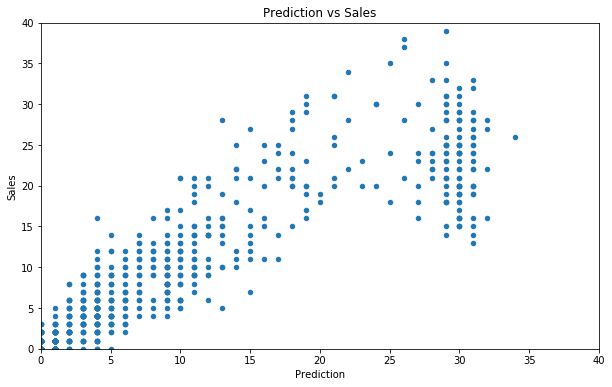

In [156]:
fitted_models['xgb'].best_estimator_.fit(X[X.Week < 51], df[df.Week  < 51].Sales)
y_hat = fitted_models['xgb'].best_estimator_.predict(X[X.Week == 51].values)
y = pd.DataFrame(df[df.Week == 51].Sales)
y['Prediction'] = np.round(y_hat)
y.plot.scatter(x='Prediction', y='Sales', figsize=(10, 6), title='Prediction vs Sales', ylim=(0,40), xlim=(0,40))
plt.show()

## Conclusions

Our model is working pretty well for products selling under 25 units. For products selling around 30 units, our model is underpredicting. This might be further investigated.

Now, to get new predictions we need the product identifier and week number as inputs and compute the new features (i.e. lag and difference features).

The model can be further optimized to produce better predictions. Find below some ideas worth trying in order to improve it:
* Investigate products with sales over 25 units
* Try more features (lags, differences) not only at the product level, but at the global
* Try a neural network